In [1]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [2]:
import cv2
import base64

import numpy as np
import matplotlib.pyplot as plt

from json import loads,dumps

%matplotlib inline

In [3]:
(X,Y),(x,y) = tf.keras.datasets.mnist.load_data()

X = X.reshape(-1,784).astype(np.float32) / 255
x = x.reshape(-1,784).astype(np.float32) / 255

Y = tf.keras.utils.to_categorical(Y)
y = tf.keras.utils.to_categorical(y)

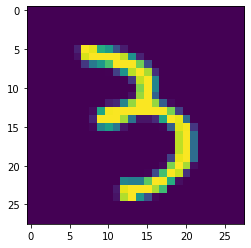

In [4]:
i = 40502
plt.imshow(X[i:i+1].reshape(28,28))

In [5]:
inp = Input(shape=(784,),name="input")

d1 = Dense(128,activation="relu",name="dense1")(inp)
d20 = Dense(48,activation="relu",)(d1)
d21 = Dense(16,activation="relu",)(d1)
c1 = concatenate([d20,d21])

d2 = Dense(32,activation="relu",name="dense5")(c1)
out = Dense(10,activation="softmax",name="out")(d2)
model = Model([inp],[out])

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense1 (Dense)                  (None, 128)          100480      input[0][0]                      
__________________________________________________________________________________________________
dense (Dense)                   (None, 48)           6192        dense1[0][0]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           2064        dense1[0][0]                     
______________________________________________________________________________________________

In [7]:
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])

In [8]:
model.fit(X,Y,batch_size=32,epochs=1,validation_data=(x,y))

1875/1875 [==============================] - 8s 4ms/step - loss: 0.2599 - accuracy: 0.9235 - val_loss: 0.1526 - val_accuracy: 0.9524


In [9]:
import numpy as np
import cv2
import base64
import matplotlib.pyplot as plt
import tensorflow as tf

from json import loads,dumps
from tensorflow.keras.layers import *

def set_levels(network,input_nodes,level):
    for node in input_nodes:
        if network[node]['level'] > -1:            
            set_levels(network,network[node]['outbound'],network[node]['level']+1)
        else:
            network[node]['level'] = level
            if len(network[node]['outbound']):
                for ob in network[node]['outbound']:
                    network[ob]['level'] = level + 1
            set_levels(network,network[node]['outbound'],network[node]['level']+1)
        
def get_conf(model:tf.keras.models.Model,input_config:dict):
    model_conf = loads(model.to_json())
    network = {
        l['name']:{
            "inbound":[],
            "outbound":[],
            "class_name":l['class_name'],
            "level":-1,
        } for l in model_conf['config']['layers']
    }

    for l in model_conf['config']['layers']:
        if len(l['inbound_nodes']):
            for n in l['inbound_nodes'][0]:
                network[l['name']]['inbound'].append(n[0])
                network[n[0]]['outbound'].append(l['name'])

    set_levels(network,input_config['input_nodes'],0)
    levels = [[] for i in range(max([i['level'] for _,i in network.items()])+1)]
    for node,val in network.items():
        levels[val['level']].append(node)
    
    for i,level in enumerate(levels):
        if not len(level):
            j = i - 1
            while j:
                if len(levels[j]) > 1:
                    levels[i] = levels[j][1:]
                    levels[j] = levels[j][:1]
                    break
                j -= 1
                
    return network,levels


def image2base64(image:np.ndarray)->str:
    image = image.astype(np.uint8) if image.max() > 1 else (image * 255).astype(np.uint8)
    retval, buffer = cv2.imencode('.png', image)
    buffer = base64.b64encode(buffer)
    return 'data:image/png;base64,' + str(buffer,encoding="utf-8")

def prepare_input_image(image:np.ndarray,layer:dict,input_config:dict):
    try:
        image = image.reshape(input_config['shape'])
        image = cv2.resize(image,(128,128))
    except ValueError:
        _,*shape = layer['instance'].output_shape
        image = image.reshape(shape)
    if len(image.shape) == 3:
        return image2base64(image[:,:,::-1])
    return image2base64(image)

transformers = {
    "prepare_input_image":prepare_input_image
}

def prep_dummy(value:np.ndarray,layer:Layer,*args,**kwargs):
    pass

def prep_input_layer(
        value:np.ndarray,
        layer:dict,
        input_config:dict,
        *args,
        **kwargs
    )->list:
    """
    Prep Function For InputLayer 
    """
    func = transformers[input_config[layer['name']]['transformer']]
    return func(value.numpy(),layer,input_config[layer['name']])

def prep_dense(
        value:np.ndarray,
        *args,
        **kwargs
    )->list:
    """
    Prep Function For Dense Layer
    """
    (value,) = value.numpy()
    return ((value.astype(float) / value.max())).tolist()

def prep_activation(
        value:np.ndarray,
        layer:Layer,
        *args,
        **kwargs
    )->list:
    pass

def prep_lstm(value:np.ndarray,layer:tf.keras.layers.Layer,*args,**kwargs):
    if layer.return_sequences:
        value,*_ = value
        _min = value.min(axis=1).reshape(-1,1)
        _max = value.max(axis=1).reshape(-1,1)
        value = ((value - _min)/(_max - _min))
        value[np.isnan(value)] = 0
        return value.astype(float).tolist()
        
    return ((value / value.max())[0]).tolist()


def prep_conv2d(
        value:np.ndarray,
        *args,
        **kwargs
    )->list:
    """
    Prep function for Conv2D layer
    """
    value = value.numpy()
    _,h,w,c = value.shape
    images = value.reshape(c,h*w).copy()
    _min =  images.min(axis=1).reshape(-1,1)
    _max =  images.max(axis=1).reshape(-1,1)
    images = (((images - _min) / (_max - _min)).reshape(c,h,w)*255).astype(np.uint8)
    images[np.isnan(images)] = 0
    _max = images.max()
    _max = _max if _max else 1
    return [ (image2base64(image),float(image.mean()/_max)) for image in images ]

def get_outputs(
        tensor,
        layer,
        input_config,
        network,
        model
    ):
    func = prep_functions[layer['config']['class_name']]
    outputs = func(
        value=tensor,
        layer=layer,
        network=network,
        input_config=input_config,
        model=model
    )
    return outputs


def prep_ext_layer(
        value:np.ndarray,
        layer:dict,
        network:dict,
        input_config:dict,
        model,
        *args,**kwargs
    ):
    (parent,*_) = network[layer['name']]['inbound']
    layer = {
        "name":parent,
        "config":network[parent],
        "instance":layer['instance']
    }
    if network[parent]['class_name'] == 'InputLayer':
        return [get_outputs(value,layer,input_config,network,model)]
    return get_outputs(value,layer,input_config,network,model)

prep_functions = {
    "Conv2D":prep_conv2d,
    "Dense":prep_dense,
    "InputLayer":prep_input_layer,
    "MaxPooling2D":prep_conv2d,
    "Flatten":prep_dense,
    "LSTM":prep_lstm,
    
    "Concatenate":prep_ext_layer,
    "Activation":prep_ext_layer,
    "Add":prep_ext_layer,
    "BatchNormalization":prep_ext_layer,
    "ZeroPadding2D":prep_ext_layer
}

def set_output(model,network:dict,levels:list,input_values:dict,input_config:dict):
    temp_out = dict()
    inputs = None
    layer = None
    layer_instance = None
    layer_config = None
    
    for level in levels:
        for layer in level:
            layer_config = network[layer]
            layer_instance = model.get_layer(layer)
            inputs = None
            if len(layer_config['inbound']):
                if len(layer_config['inbound']) < 2:
                    inputs,*_ = [temp_out[i] for i in layer_config['inbound']]
                else:
                    inputs = [temp_out[i] for i in layer_config['inbound']]
                    
                out = layer_instance(inputs)
                temp_out[layer] = out
                
                network[layer]['outputs'] = get_outputs(
                    tensor=out,
                    layer={
                        "name":layer,
                        "config":layer_config,
                        "instance":layer_instance
                    },
                    input_config=input_config,
                    network=network,
                    model=model
                )
            else:
                inputs = input_values[layer]
                out = layer_instance(inputs['value'].astype(np.float32))
                temp_out[layer] = out
                
                network[layer]['outputs'] = prep_functions[layer_config['class_name']](
                    value=out,
                    layer ={
                        "name":layer,
                        "config":layer_config,
                        "instance":layer_instance
                    },
                    input_config = input_config,
                    network=network,
                    model=model
                )

In [11]:
input_config = {
    "examples":[
        {
            "name":f"ex_{i}_class_{str(y[i])}",
            "input":{ 
                "value":x[i:i+1],
            },
            "output":str(y[i])
        }
        for i in np.random.randint(0,len(x),20)
    ],
    "input_layers_config":{
        "input":{
            "type":"image",
            "shape":(28,28),
            "transformer":"prepare_input_image",
            "resize":(128,128)
        }
    },
    "input_nodes":['input']
}

In [13]:
network,levels = get_conf(model,input_config)

In [16]:
set_output(
    model=model,
    network=network,
    levels=levels,
    input_values=input_config['examples'][0],
    input_config=input_config['input_layers_config']
)

{'input': {'inbound': [],
  'outbound': ['dense1'],
  'class_name': 'InputLayer',
  'level': 0,
  'outputs': ''},
 'dense1': {'inbound': ['input'],
  'outbound': ['dense', 'dense_1'],
  'class_name': 'Dense',
  'level': 1,
  'outputs': [0.0,
   0.1548784098587602,
   0.22167953133064408,
   0.0,
   0.3233906890589262,
   0.020254657884176804,
   0.014476697381244784,
   0.18831476189883145,
   0.0,
   0.10044813660937377,
   0.0,
   0.0,
   0.0,
   0.0069899754832322015,
   0.08309858435059805,
   0.0,
   0.31858222791748175,
   0.04922563143961056,
   0.32015806475895064,
   0.0,
   0.688752206579362,
   0.755377319698068,
   0.0,
   0.929699596613542,
   0.568753910454841,
   0.0,
   0.0,
   0.6960822326014862,
   0.0,
   0.3099859777440358,
   0.0,
   0.0,
   0.0,
   0.6014494183182926,
   0.0,
   0.2753032396888807,
   0.1476944558911715,
   0.0,
   0.02488358217060731,
   0.0,
   0.6727130183250375,
   0.42081153296662904,
   0.0,
   0.0,
   0.0,
   0.0,
   0.1506960898923263,
   
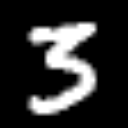

In [17]:
network

In [10]:
model.save_weights("./saved_model/mnist_dense_diff")
open("./saved_model/mnist_dense_diff.json","w+").write(model.to_json())

3011